In [70]:
import os
import numpy as np
import pandas as pd

**path指定**

In [71]:
base_dir = '/content/drive/MyDrive/kaggle/signLanguage/csv'
train_dir = base_dir + '/train'
test_dir = base_dir + '/test'

#trainのデータ読み込み

In [72]:
# dir内のフォルダ数を数える
folder_count = 0
dir = train_dir
for path in os.listdir(dir):
    if os.path.isdir(os.path.join(dir, path)):
        folder_count += 1
print(folder_count)

20


In [73]:
for i in range(1,folder_count+1):
    exec_command = 'train_sign' + str(i) + "_path = train_dir + '/sign_" + str(i) + "/'"
    exec(exec_command)
    #print(exec_command)

In [74]:
train_sign1_path  # パス確認

'/content/drive/MyDrive/kaggle/signLanguage/csv/train/sign_1/'

In [75]:
frame = 60
Y=[]
for i in range(1,folder_count+1):
    # sign1-sign20のpathを指定
    path_exec_command = 'path = train_sign' + str(i) + '_path'
    exec(path_exec_command)
    #print(path_exec_command)

    files=os.listdir(path)
    #print(files)
    lists=[]  # 同じsignのデータを3次元listに格納する
    for file in files:
        #print(file)
        df = pd.read_csv(path+file, index_col=0)

        df = df.iloc[:,1404:]  # 顔の情報を削除468x3
        df = df.iloc[:,63:]  # 左手の情報を削除21x3

        df = df.fillna(0.1)  # 欠損データ

        # フレームの補完．60フレームに足りない場合は最後のフレームで補完     
        if len(df) < frame:
            for f in range(len(df), frame):
                df=df.append(df.tail(1))
        #print(df)

        lists.append(df.values[:frame, :].tolist())  # signごとに結合
        Y.append(i - 1)# ラベル
    csv_exec_command = 'train_sign' + str(i) + '= np.array(lists)'
    exec(csv_exec_command)
    #print(csv_exec_command)

In [76]:
print(train_sign1.shape) # 動画数,フレーム数,特徴量

(40, 60, 162)


In [77]:
from keras.utils import np_utils

Y = np.array(Y)
Y = np_utils.to_categorical(Y)
Y.shape

(800, 20)

**trainデータの結合**

In [78]:
X=train_sign1
for i in range(2, folder_count+1):
    exec_command = 'X = np.concatenate([X, train_sign'+ str(i) +'], 0)'
    #print(exec_command)
    exec(exec_command)

print(X.shape)

(800, 60, 162)


#モデルの構成

In [95]:
from keras.layers.advanced_activations import LeakyReLU
from keras import layers
from keras import models
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout,LeakyReLU
from keras import optimizers

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=X.shape[1:]))
    model.add(Dense(Y.shape[1], activation='softmax'))
    
    #model.summary()    

    opt = Adam(lr=0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

    return model

#k-foldを使ったデータの分割と学習

参考：https://zenn.dev/monda/articles/kaggle-cv-template

In [96]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

FOLD = 10
EPOCH = 325
BATCH_SIZE = None

valid_scores = []
models = []
kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    X_train, X_valid = X[train_indices], X[valid_indices]
    y_train, y_valid = Y[train_indices], Y[valid_indices]

    model = build_model()

    rlr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.1,
                            patience=3,
                            verbose=0,
                            min_delta=1e-4,
                            mode='max')
    ckp = ModelCheckpoint(f'model_{fold}.hdf5',
                          monitor='val_loss',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=True,
                          mode='max')
    es = EarlyStopping(monitor='val_loss',
                       min_delta=1e-4,
                       patience=50,
                       mode='max',
                       baseline=None,
                       restore_best_weights=True,
                       verbose=0)

    h = model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              epochs=EPOCH,
              batch_size=BATCH_SIZE,
              callbacks=[rlr, ckp, es],
              verbose=0)

    y_valid_pred = model.predict(X_valid)
    score = mean_absolute_error(y_valid, y_valid_pred)
    print(f'fold {fold} MAE: {score}')
    valid_scores.append(score)

    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')  # 平均絶対誤差

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 0 MAE: 0.09396786242723465


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 1 MAE: 0.09445670247077942


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 2 MAE: 0.09405235946178436


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 3 MAE: 0.09285817295312881


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 4 MAE: 0.09408284723758698


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 5 MAE: 0.0934428796172142


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 6 MAE: 0.09379337728023529


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 7 MAE: 0.09380287677049637


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 8 MAE: 0.09441874921321869


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fold 9 MAE: 0.0942365899682045
CV score: 0.09391124546527863


#trainデータの分割と学習

In [97]:
# from sklearn.model_selection import train_test_split

# train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.1)

In [98]:
# model = build_model()

# h=model.fit(train_x, 
#             train_y, 
#             epochs= 325, 
#             verbose=1, 
#             validation_data=(val_x, val_y))

#グラフ表示

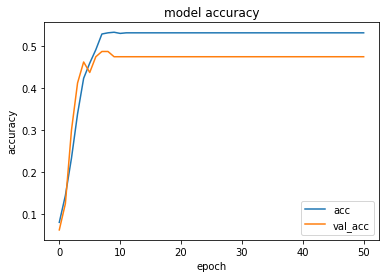

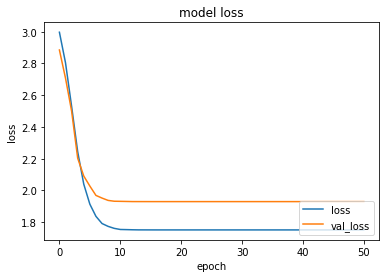

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(h)

In [100]:
# 学習結果を保存する
hdf5_file = os.path.join(base_dir, '../LSTM.hdf5')
model.save(hdf5_file)